In [1]:
import nltk
import json

In [7]:
from tqdm import tqdm

In [2]:
file_d = []
reviews_sent = []
reviews_neg_sent = []
reviews_str = ""

In [3]:
file = '/Users/gkhanna/Downloads/reviews_Home_and_Kitchen_5.json'

In [4]:
# Reading count number of JSON lines from the file
count = 20000
n = 0
with open(file, "r") as f:
    for line in f:
        file_d.append(json.loads(line))
        n =  n + 1
        if n == count:
            break
    


In [5]:
# Checking the structures
print(len(file_d))
print(type(file_d))
print(file_d[0])
print(type(file_d[0]))

20000
<class 'list'>
{'reviewerID': 'APYOBQE6M18AA', 'asin': '0615391206', 'reviewerName': 'Martin Schwartz', 'helpful': [0, 0], 'reviewText': 'My daughter wanted this book and the price on Amazon was the best.  She has already tried one recipe a day after receiving the book.  She seems happy with it.', 'overall': 5.0, 'summary': 'Best Price', 'unixReviewTime': 1382140800, 'reviewTime': '10 19, 2013'}
<class 'dict'>


In [6]:
print(file_d[0]['reviewText'])

My daughter wanted this book and the price on Amazon was the best.  She has already tried one recipe a day after receiving the book.  She seems happy with it.


In [8]:
# Getting the reviews out of the dictionary
# into a list and string
for r in tqdm(file_d):
    reviews_sent.append(r['reviewText'])
    reviews_str = reviews_str + str(r['reviewText'])

100%|██████████| 20000/20000 [00:00<00:00, 403093.04it/s]


In [9]:
print(type(reviews_sent))
print(len(reviews_sent))
print(reviews_sent[0])

<class 'list'>
20000
My daughter wanted this book and the price on Amazon was the best.  She has already tried one recipe a day after receiving the book.  She seems happy with it.


In [10]:
len(reviews_str)

9864595

In [11]:
print(reviews_str[:30])

My daughter wanted this book a


Tokenize the sentences
PunktSentence Tokenizer breaks the text into a list of sentences
PunktSentenceTokenizer is customized to separate sentences on a few extra words and characters as well

In [12]:
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktLanguageVars
'''We customize the ReviewLangVars class to separate sentences based on some additional keywords'''


class ReviewLangVars(PunktLanguageVars):
    sent_end_chars = ('pros:', 'cons:', '[','][','.','?','!')
    
sent_tokenizer1 = PunktSentenceTokenizer(lang_vars = ReviewLangVars())
# sent_tokenizer1 = PunktSentenceTokenizer()
sent_fullreview = sent_tokenizer1.tokenize(reviews_str)

In [13]:
# This are the original sentences tokenized
print(sent_fullreview[0])
print(sent_fullreview[:5])
len(sent_fullreview)

My daughter wanted this book and the price on Amazon was the best.
['My daughter wanted this book and the price on Amazon was the best.', 'She has already tried one recipe a day after receiving the book.', 'She seems happy with it.I bought this zoku quick pop for my daughterr with her zoku quick maker.', 'She loves it and have fun to make her own ice cream.There is no shortage of pop recipes available for free on the web, but I purchased the "Zoku Quick Pops" book, because Zoku has some good recipes for fruit pops on its blog.', 'I was hoping there were more where those came from.']


89141

Extracting common features using apriori
https://github.com/asaini/Apriori

In [14]:
import sys

from itertools import chain, combinations
from collections import defaultdict
from optparse import OptionParser


def subsets(arr):
    """ Returns non empty subsets of arr"""
    return chain(*[combinations(arr, i + 1) for i, a in enumerate(arr)])


def returnItemsWithMinSupport(itemSet, transactionList, minSupport, freqSet):
        """calculates the support for items in the itemSet and returns a subset
       of the itemSet each of whose elements satisfies the minimum support"""
        _itemSet = set()
        localSet = defaultdict(int)

        for item in itemSet:
                for transaction in transactionList:
                        if item.issubset(transaction):
                                freqSet[item] += 1
                                localSet[item] += 1

        for item, count in localSet.items():
                support = float(count)/len(transactionList)

                if support >= minSupport:
                        _itemSet.add(item)

        return _itemSet


def joinSet(itemSet, length):
        """Join a set with itself and returns the n-element itemsets"""
        return set([i.union(j) for i in itemSet for j in itemSet if len(i.union(j)) == length])


def getItemSetTransactionList(data_iterator):
    transactionList = list()
    itemSet = set()
    for record in data_iterator:
        transaction = frozenset(record)
        transactionList.append(transaction)
        for item in transaction:
            itemSet.add(frozenset([item]))              # Generate 1-itemSets
    return itemSet, transactionList


def runApriori(data_iter, minSupport, minConfidence):
    """
    run the apriori algorithm. data_iter is a record iterator
    Return both:
     - items (tuple, support)
     - rules ((pretuple, posttuple), confidence)
    """
    itemSet, transactionList = getItemSetTransactionList(data_iter)

    freqSet = defaultdict(int)
    largeSet = dict()
    # Global dictionary which stores (key=n-itemSets,value=support)
    # which satisfy minSupport

    assocRules = dict()
    # Dictionary which stores Association Rules

    oneCSet = returnItemsWithMinSupport(itemSet,
                                        transactionList,
                                        minSupport,
                                        freqSet)

    currentLSet = oneCSet
    k = 2
    while(currentLSet != set([])):
        largeSet[k-1] = currentLSet
        currentLSet = joinSet(currentLSet, k)
        currentCSet = returnItemsWithMinSupport(currentLSet,
                                                transactionList,
                                                minSupport,
                                                freqSet)
        currentLSet = currentCSet
        k = k + 1

    def getSupport(item):
            """local function which Returns the support of an item"""
            return float(freqSet[item])/len(transactionList)

    toRetItems = []
    for key, value in tqdm(list(largeSet.items())):
        toRetItems.extend([(tuple(item), getSupport(item))
                           for item in value])

    toRetRules = []
    for key, value in tqdm(list(largeSet.items())[1:]):
        for item in value:
            _subsets = map(frozenset, [x for x in subsets(item)])
            for element in _subsets:
                remain = item.difference(element)
                if len(remain) > 0:
                    confidence = getSupport(item)/getSupport(element)
                    if confidence >= minConfidence:
                        toRetRules.append(((tuple(element), tuple(remain)),
                                           confidence))
    return toRetItems, toRetRules


def printResults(items):
    """prints the generated itemsets sorted by support and the confidence rules sorted by confidence"""
    for item, support in sorted(items, key=lambda item_support: item_support[1], reverse=True):
        print(str(item), support)

In [15]:
# Utility functions
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

lem = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()
lem_word_mapping = {}

# Find leaves of a tree
def leaves(tree):
    """Finds leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label() in ['P1','P2','P3','P4','P5','P6','P7','P8']):
        yield subtree.leaves()
    
def stem(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = word.replace("'","").replace('"','').replace('.','')
    word1 = stemmer.stem(word)
    return word1

# lowercase, stem and lemmatize
def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word1 = stemmer.stem(word)
    word2 = lem.lemmatize(word1)
    if word != word2:
        lem_word_mapping[word2] = word
    return word2

def acceptableWord(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool((2 <= len(word) <= 40) and word.lower() not in stopwords)
    return accepted

# extract words after normalizing and checking if acceptable
def getTerms(tree):
    """Returns the words after checking acceptable conditions, normalizing and lemmatizing"""
    term = [ stem(w) for w in tree if acceptableWord(w) ]
    return term
    
def getNorm(tree):
    """Parse leaves in chunk and return after checking acceptable conditions, normalizing and lemmatizing"""
    for leaf in leaves(tree):
        term = [ normalise(w) for w,t in leaf if acceptableWord(w) ]
        yield term

Set of nouns for each sentence. These represent the items that the review may be about

In [16]:
# Set of nouns for the apriori algorithm

def isNoun(n):
    if n=='NN' or n=='NNS' or n=='NNP' or n=='NNPS':
        return True

revset=[]
for line in tqdm(sent_fullreview):
    # print(line)
    a = nltk.word_tokenize(line)
    # print(a)
    nouns = [word for (word, pos) in nltk.pos_tag(a) if isNoun(pos)] 
    # print(nouns)
    terms = getTerms(nouns)
    # print(terms)

    revset.append(terms)



100%|██████████| 89141/89141 [02:23<00:00, 621.71it/s]


In [17]:
print(revset[0])
print(revset[:10])

['daughter', 'book', 'price', 'amazon']
[['daughter', 'book', 'price', 'amazon'], ['recip', 'day', 'book'], ['zoku', 'pop', 'daughterr', 'zoku', 'quick', 'maker'], ['fun', 'ice', 'shortag', 'pop', 'recip', 'web', 'zoku', 'quick', 'pop', 'book', 'zoku', 'recip', 'fruit', 'pop', 'blog'], [], ['book', 'dessert', 'pop'], ['recip', 'total', 'pop'], ['fresh', 'fruiti', 'chapter', 'chapter', 'pop', 'quick', 'pop'], ['shop', 'coco', 'loco'], ['recip', 'chocolatechapt', 'tip', 'techniqu']]


In [18]:
len(revset)

89141

Below are the most common Items in the reviews. Assumption is that the most common nouns are the ones that the reviewer is reviewing. 

In [19]:
items, rules = runApriori(revset, 0.01, 0.05)
printResults(items)

100%|██████████| 1/1 [00:00<00:00, 2398.12it/s]
0it [00:00, ?it/s]

('time',) 0.0604211305684253
('year',) 0.04476054789602989
('product',) 0.039173893045848715
('thing',) 0.03389012912127977
('cup',) 0.031108019878619265
('handl',) 0.03090609259487778
('pan',) 0.02861758337914091
('water',) 0.02844931064268967
('use',) 0.027933274250905867
('coffe',) 0.02609349233237231
('kitchen',) 0.02576816504189991
('hand',) 0.025274565014976273
('bowl',) 0.024556601339450982
('size',) 0.024365892238139578
('food',) 0.023849855846355773
('review',) 0.023311383089711805
('lot',) 0.021976419380531968
('qualiti',) 0.02194276483324172
('way',) 0.02178571027922056
('problem',) 0.02086581931995378
('price',) 0.020663892036212293
('set',) 0.020506837482191134
('one',) 0.02039465565789031
('oxo',) 0.01967669198236502
('oil',) 0.018667055563657577
('machin',) 0.018465128279916088
('item',) 0.017904219158411953
('bit',) 0.017870564611121707
('plastic',) 0.01763498278008997
('job',) 0.017096510023446
('steel',) 0.01645707362493129
('blade',) 0.016120528152028808
('pot',) 0.0

In [20]:
# Convert into tokens/words
all_sen_tok = []
for sentence in tqdm(sent_fullreview):
    all_sen_tok.append(nltk.word_tokenize(sentence))

100%|██████████| 89141/89141 [00:13<00:00, 6502.29it/s]


In [21]:
print(all_sen_tok[0])
print(all_sen_tok[:2])

['My', 'daughter', 'wanted', 'this', 'book', 'and', 'the', 'price', 'on', 'Amazon', 'was', 'the', 'best', '.']
[['My', 'daughter', 'wanted', 'this', 'book', 'and', 'the', 'price', 'on', 'Amazon', 'was', 'the', 'best', '.'], ['She', 'has', 'already', 'tried', 'one', 'recipe', 'a', 'day', 'after', 'receiving', 'the', 'book', '.']]


In [22]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/gkhanna/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [23]:
# Gave an error without downloading the nltk averaged_perceptron_tagger
# Find POS tags to the tokens
all_sen_tok_tagged = []
for sentence_t in tqdm(all_sen_tok):
    all_sen_tok_tagged.append(nltk.tag.pos_tag(sentence_t))

100%|██████████| 89141/89141 [01:34<00:00, 948.29it/s] 


In [26]:
print(all_sen_tok_tagged[0])

[('My', 'PRP$'), ('daughter', 'NN'), ('wanted', 'VBD'), ('this', 'DT'), ('book', 'NN'), ('and', 'CC'), ('the', 'DT'), ('price', 'NN'), ('on', 'IN'), ('Amazon', 'NNP'), ('was', 'VBD'), ('the', 'DT'), ('best', 'JJS'), ('.', '.')]


Extract phrases that talk about features and associated sentiment/opinion after POS tagging.

In [24]:
# Patterns that we want to extract
# We think these are the ones that contain features
feature_patterns = r"""       
    P1:{<JJ><NN|NNS>}
    P2:{<JJ><NN|NNS><NN|NNS>}
    P3:{<RB|RBR|RBS><JJ>}
    P4:{<RB|RBR|RBS><JJ|RB|RBR|RBS><NN|NNS>}
    P5:{<RB|RBR|RBS><VBN|VBD>}
    P6:{<RB|RBR|RBS><RB|RBR|RBS><JJ>}
    P7:{<VBN|VBD><NN|NNS>}
    P8:{<VBN|VBD><RB|RBR|RBS>}
"""

In [25]:
len(revset)

89141

In [27]:
def getTerms1(tree):
    """Returns the words after checking acceptable conditions, normalizing and lemmatizing"""
    term = [ normalise(w) for w in tree if acceptable_word(w) ]
    yield term

In [29]:
# Extract feature phrases with ngram rules
def extractFeaturePhrases(tagged):
    out = []
    for phrase in tqdm(tagged):
        r_parser = nltk.RegexpParser(feature_patterns)
        chunk_2 = r_parser.parse(phrase)
        term = getNorm(chunk_2)
        
        for ter in term:
            word_concat = ""
            for word in ter:
                word_concat = word_concat + " " + word
                
            if (len(ter) > 1):
                out.append(word_concat)
        
    return out

extracted = extractFeaturePhrases(all_sen_tok_tagged)
        


 42%|████▏     | 37550/89141 [00:28<00:37, 1368.64it/s]


 84%|████████▍ | 74771/89141 [00:56<00:10, 1391.40it/s]


100%|██████████| 89141/89141 [01:07<00:00, 1311.33it/s]

In [30]:
print(extracted[:10])

[' alreadi tri', ' quick pop', ' good recip', ' sweet dessert', ' fruit pop', ' dessert pop', ' pop recip', ' detail inform', ' differ type', ' decor fruit']


Find out the most common ones, frequency distribution

In [31]:
freqdist = nltk.FreqDist(word for word in extracted)

In [32]:
type(freqdist)

nltk.probability.FreqDist

In [33]:
most_common = freqdist.most_common()
print(most_common[:10])

[(' well made', 502), (' long time', 356), (' oliv oil', 330), (' first time', 327), (' stainless steel', 308), (' good qualiti', 250), (' high qualiti', 246), (' hot water', 234), (' mani year', 229), (' great job', 221)]


In [34]:
freqdist.pprint(maxlen = 20)

FreqDist({' well made': 502, ' long time': 356, ' oliv oil': 330, ' first time': 327, ' stainless steel': 308, ' good qualiti': 250, ' high qualiti': 246, ' hot water': 234, ' mani year': 229, ' great job': 221, ' great product': 208, ' sever time': 189, ' heavi duti': 178, ' littl bit': 173, ' perfect size': 170, ' sever year': 167, ' good job': 160, ' mash potato': 135, ' small amount': 129, ' good product': 125, ...})


In [35]:
print(freqdist.max())

 well made


In [44]:
freq_tab = freqdist.tabulate(7)

       well made        long time         oliv oil       first time  stainless steel     good qualiti     high qualiti 
             502              356              330              327              308              250              246 


In [37]:
type(freq_tab)

NoneType

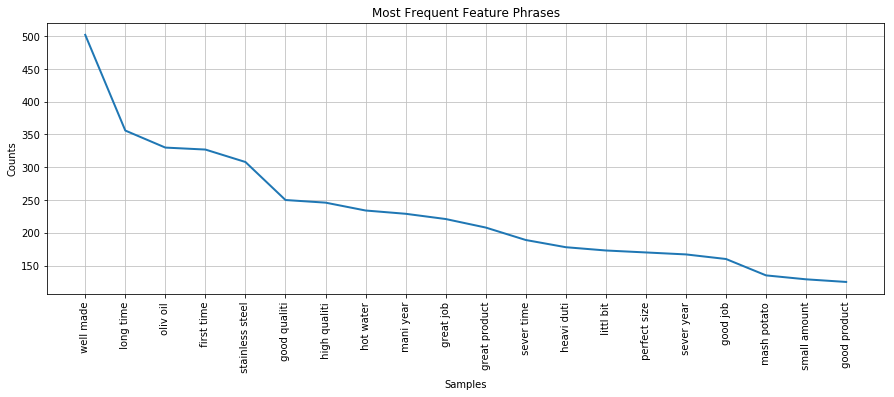

In [43]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))  # We want a bigger size plot
freqdist.plot(20, title = "Most Frequent Feature Phrases", cumulative = False)

Unlemmatize and unstem using the dictionary created earlier

In [45]:
import inflect

In [46]:
print(extracted[:10])

[' alreadi tri', ' quick pop', ' good recip', ' sweet dessert', ' fruit pop', ' dessert pop', ' pop recip', ' detail inform', ' differ type', ' decor fruit']


In [47]:
p = inflect.engine()
def replacewords(mc):
    newmc=[]
    for a in tqdm(mc):
        newword="";found=False;
        for b in a[0].split():            
            for x in lem_word_mapping:
                #print(x)
                #print(b)
                if b==x:
                    found=True
                    sing=(lem_word_mapping[x] if p.singular_noun(lem_word_mapping[x])==False else p.singular_noun(lem_word_mapping[x]))
                    if newword=="":
                        newword = newword + sing
                    else:
                        newword = newword + " " +  sing
            if found==False:
                if newword=="":
                    newword = newword + b
                else:
                    newword = newword + " " +  b
                    #print(newword)
        newmc.append((newword,a[1]))
    return newmc

final = replacewords(most_common)

print("Top Feature Phrases:")
print(final[0])
print(final[:50])


 50%|█████     | 23314/46371 [00:29<00:25, 917.70it/s]


 97%|█████████▋| 44764/46371 [00:58<00:02, 776.56it/s]


100%|██████████| 46371/46371 [01:00<00:00, 760.87it/s]

Top Feature Phrases:
('well', 502)
[('well', 502), ('long time', 356), ('olive oil', 330), ('first time', 327), ('stainless steel', 308), ('good quality', 250), ('high quality', 246), ('hot water', 234), ('many year', 229), ('greatful job', 221), ('greatful product', 208), ('several time', 189), ('heavy duty', 178), ('little bit', 173), ('perfection sized', 170), ('several year', 167), ('good job', 160), ('mashed potato', 135), ('small amount', 129), ('good product', 125), ('rightfully sized', 123), ('good grip', 123), ('french pressed', 123), ("n't used", 116), ('ever used', 116), ('many time', 114), ('salad spinner', 108), ('reason priced', 105), ('bigged deal', 105), ('greatful priced', 103), ('popcorn popper', 103), ('light weighted', 100), ('highly recommended', 100), ('never used', 98), ('hardnes cheese', 97), ('good thing', 94), ('sharpnes edge', 90), ('french fried', 89), ('good priced', 85), ('next time', 85), ('different sized', 84), ('dishwasher safely', 83), ('iced cream', 

We'll find out the opinions corresponding to the most common features

In [53]:
def featuresInContext(item_arr, opinion_phrases, sentence_arr ):
    for item,support in tqdm(sorted(item_arr, key=lambda item_support: item_support[1], reverse=True)):
        count = 0
        print("------" + "Item > " + item[0] + "------")
        for phrase, freq in sorted(opinion_phrases, key = lambda phrase_freq: phrase_freq[1], reverse = True):
            pcount = 0
            if normalise(item[0]) in normalise(phrase):
                count+=1
                print("---" + "Phrase > " + phrase + "----")
                for l in sentence_arr:
                    if normalise(phrase) in normalise(l):
                        # print("Debug: " + l)
                        for b in zip(l.split(" ")[:-1], l.split(" ")[1:]):
                            #print(b[0]+" "+b[1])
                            if normalise(b[0])==normalise(item[0]):
                                print("---" + "examplex" + "----")
                                print(l.replace("'","").replace("]","").replace("[",""))
                                pcount+=1
                                break
                            elif (normalise(b[0])+" "+normalise(b[1]))==normalise(item[0]):
                                print("---" + "exampley" + "----")
                                print(l.replace("'","").replace("]","").replace("[",""))
                                pcount+=1
                                break
                        if pcount==5:
                            break                
            if count==5:
                break 
        
# sent_str = ""
# sent_str = sent_str.join(sent_fullreview)
# token_sentences = sent_tokenizer1.tokenize(sent_str)
# featuresInContext(items, final, sent_fullreview)

In [54]:
print(len(items))
items_few = items[:1]
print(len(items_few))
print(items_few)

69
1
[(('pot',), 0.015952255415577567)]


In [55]:
print(items[0])

(('pot',), 0.015952255415577567)


In [57]:
featuresInContext(items_few, final, sent_fullreview)


  0%|          | 0/1 [00:00<?, ?it/s]

------Item > pot------
---Phrase > mashed potato----
---examplex----
I read the instruction booklet and the first night made mashed potatoes and a pot roast.
---examplex----
When you place the rubber part over the pot, you can rice your potatoes back into the pot (after draining the water out) and the rubber thing holds the ricer in place.The Potatoes come out riced, the lumps are gone and thats the key to great mashed potatoes.
---Phrase > sweetnes potato----
---Phrase > full pot----
---examplex----
6 months later, today, with a full pot of coffee on board, it burst into flame!
---examplex----
I can bring a full pot to full pressure in about 7 minutes on my portable induction burner.
---examplex----
It works exactly as the small one does, making a full pot in about 10 minutes.
---examplex----
I usually make a full pot in the a.m., unplug it and reheat again in the p.m.
---examplex----
Because it holds hot water in its tank, it brews a full pot of coffee in about 3 minutes.
---Phrase >


100%|██████████| 1/1 [00:23<00:00, 23.92s/it]


---examplex----
Its industrial, heats fast and doesnt use enormous amounts of propane and holds this large pot with ease.If you want to build your food pantry quickly, the 930 is the beast you need!Buy one!JohnI have an old Mirro canner I have had forever.
---examplex----
And, you dont need to buy an enameled water bath canner if you have this because you can use it without pressure too--using steam, which is easier and safer than having to deal with a large pot of boiling water on top of a stove.
